In [4]:
!unzip archive.zip

Archive:  archive.zip
  inflating: weatherAUS.csv          


In [136]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

# Ładowanie danych

In [5]:
data = pd.read_csv("./weatherAUS.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# O danych

Dane zawierają dzienne obserwacje sporządzone na przestrzeni 10 lat w różnych miejscach w Australii.  

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

# Wizualizacja i czyszczenie danych

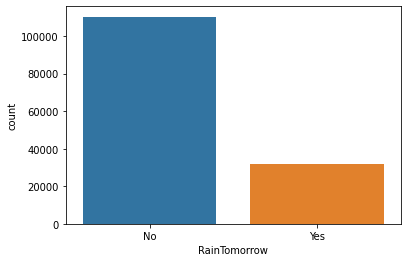

In [8]:
sns.countplot(x = data["RainTomorrow"])

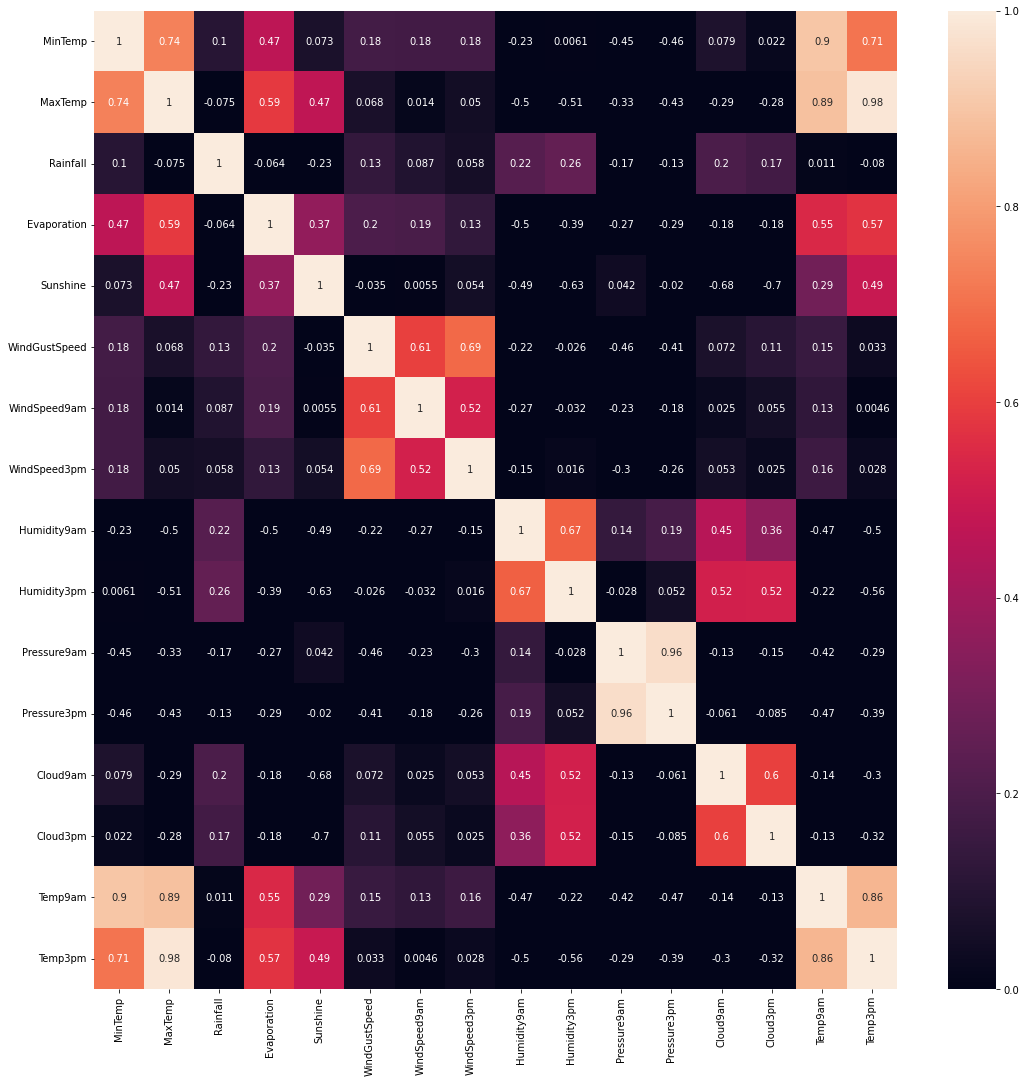

In [17]:
plt.subplots(figsize=(18,18))
sns.heatmap(data.corr(), vmin=0, vmax=1,annot=True)

In [81]:
data["Date"] = pd.to_datetime(data["Date"])

In [82]:
data["normalizedDate"] = data["Date"].dt.dayofyear / 365

In [83]:
data["year"] = data["Date"].dt.year

In [84]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,normalizedDate,year
0,2008-12-01,Albury,13.4,22.9,0.6,4.8,8.4,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,No,No,0.920548,2008
1,2008-12-02,Albury,7.4,25.1,0.0,4.8,8.4,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,No,No,0.923288,2008
2,2008-12-03,Albury,12.9,25.7,0.0,4.8,8.4,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,No,No,0.926027,2008
3,2008-12-04,Albury,9.2,28.0,0.0,4.8,8.4,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,No,No,0.928767,2008
4,2008-12-05,Albury,17.5,32.3,1.0,4.8,8.4,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.931507,2008


Text(0.5, 0, 'Kolejne dni od poczatku eksperymentu')

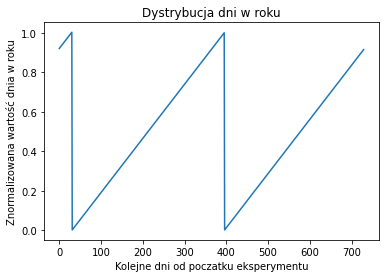

In [55]:
plot = data[:365*2]["normalizedDate"].plot()
plot.set_title("Dystrybucja dni w roku")
plot.set_ylabel("Znormalizowana wartość dnia w roku")
plot.set_xlabel("Kolejne dni od poczatku eksperymentu")

In [71]:
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Wartości zawierające typ złożony")
print(object_cols)

Wartości zawierające typ złożony
['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [72]:
# brakujace wartosci dla poszczegolnych parametrow

for i in object_cols:
    print(i, data[i].isnull().sum())

Date 0
Location 0
WindGustDir 0
WindDir9am 0
WindDir3pm 0
RainToday 0
RainTomorrow 0


In [75]:
# wypełniam modą

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

In [76]:
# lista numerycznych parametrów

t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Parametry numeryczne:")
print(num_cols)

Parametry numeryczne:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'normalizedDate']


In [77]:
for i in num_cols:
  print(i, data[i].isnull().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609
normalizedDate 0


In [78]:
# Filling missing values with median of the column in value

for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)
    
data.info() # powinno nie byc juz wartosci null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Date            145460 non-null  object 
 1   Location        145460 non-null  object 
 2   MinTemp         145460 non-null  float64
 3   MaxTemp         145460 non-null  float64
 4   Rainfall        145460 non-null  float64
 5   Evaporation     145460 non-null  float64
 6   Sunshine        145460 non-null  float64
 7   WindGustDir     145460 non-null  object 
 8   WindGustSpeed   145460 non-null  float64
 9   WindDir9am      145460 non-null  object 
 10  WindDir3pm      145460 non-null  object 
 11  WindSpeed9am    145460 non-null  float64
 12  WindSpeed3pm    145460 non-null  float64
 13  Humidity9am     145460 non-null  float64
 14  Humidity3pm     145460 non-null  float64
 15  Pressure9am     145460 non-null  float64
 16  Pressure3pm     145460 non-null  float64
 17  Cloud9am  

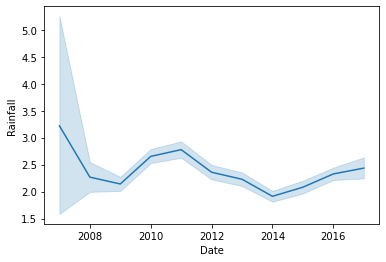

In [85]:
sns.lineplot(x=data["Date"].dt.year, y = "Rainfall", data=data)

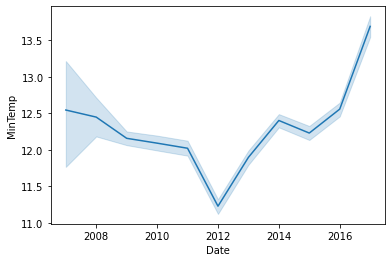

In [86]:
sns.lineplot(x=data["Date"].dt.year, y = "MinTemp", data=data)

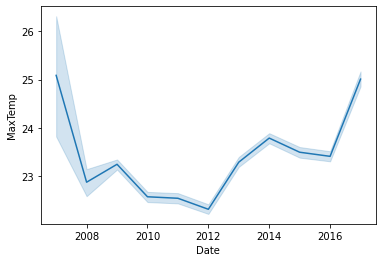

In [87]:
sns.lineplot(x=data["Date"].dt.year, y = "MaxTemp", data=data)

# Preprocesing danych

In [89]:
# Zastosowanie LabelEncodera do wszystkich kolumn zawierajacych obiektowe dane
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Date            145460 non-null  int64  
 1   Location        145460 non-null  int64  
 2   MinTemp         145460 non-null  float64
 3   MaxTemp         145460 non-null  float64
 4   Rainfall        145460 non-null  float64
 5   Evaporation     145460 non-null  float64
 6   Sunshine        145460 non-null  float64
 7   WindGustDir     145460 non-null  int64  
 8   WindGustSpeed   145460 non-null  float64
 9   WindDir9am      145460 non-null  int64  
 10  WindDir3pm      145460 non-null  int64  
 11  WindSpeed9am    145460 non-null  float64
 12  WindSpeed3pm    145460 non-null  float64
 13  Humidity9am     145460 non-null  float64
 14  Humidity3pm     145460 non-null  float64
 15  Pressure9am     145460 non-null  float64
 16  Pressure3pm     145460 non-null  float64
 17  Cloud9am  

In [90]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,normalizedDate,year
0,396,2,13.4,22.9,0.6,4.8,8.4,13,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,0,0,0.920548,2008
1,397,2,7.4,25.1,0.0,4.8,8.4,14,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,0,0,0.923288,2008
2,398,2,12.9,25.7,0.0,4.8,8.4,15,46.0,13,15,19.0,26.0,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,0,0,0.926027,2008
3,399,2,9.2,28.0,0.0,4.8,8.4,4,24.0,9,0,11.0,9.0,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,0,0,0.928767,2008
4,400,2,17.5,32.3,1.0,4.8,8.4,13,41.0,1,7,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,0.931507,2008


In [101]:
features = data.drop(["Date"],axis=1)

In [102]:
features.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,normalizedDate,year
0,2,13.4,22.9,0.6,4.8,8.4,13,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,0,0,0.920548,2008
1,2,7.4,25.1,0.0,4.8,8.4,14,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,0,0,0.923288,2008
2,2,12.9,25.7,0.0,4.8,8.4,15,46.0,13,15,19.0,26.0,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,0,0,0.926027,2008
3,2,9.2,28.0,0.0,4.8,8.4,4,24.0,9,0,11.0,9.0,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,0,0,0.928767,2008
4,2,17.5,32.3,1.0,4.8,8.4,13,41.0,1,7,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,0.931507,2008


In [103]:
target = data["RainTomorrow"]

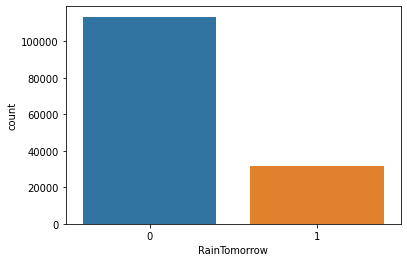

In [122]:
sns.countplot(x = target)

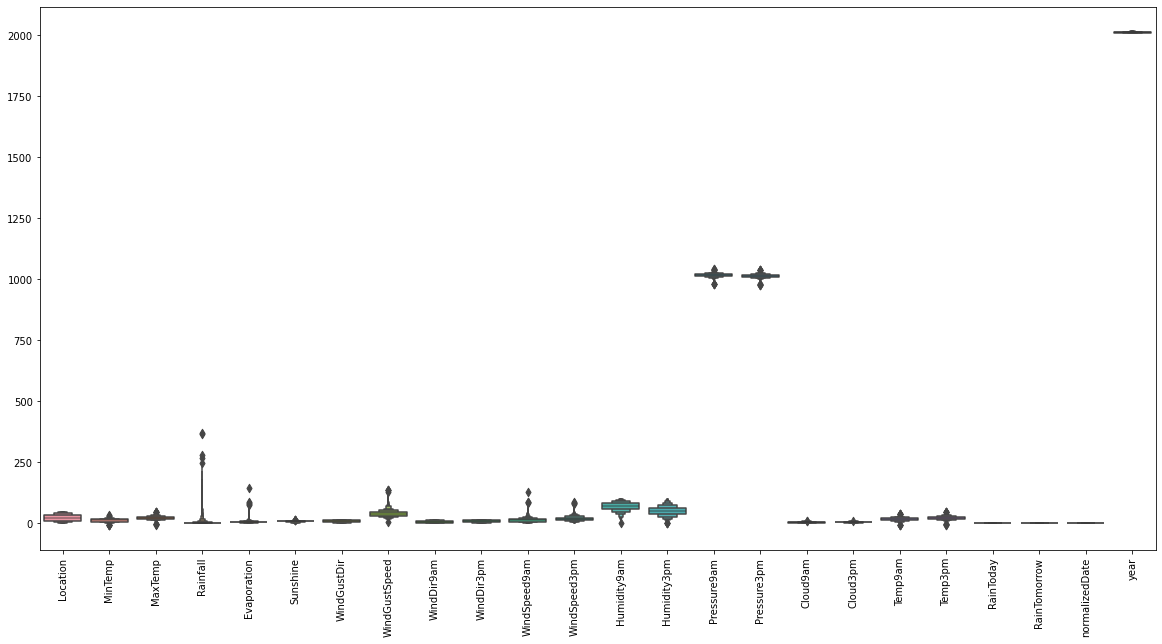

In [104]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
plt.xticks(rotation=90)
plt.show()

In [105]:
#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

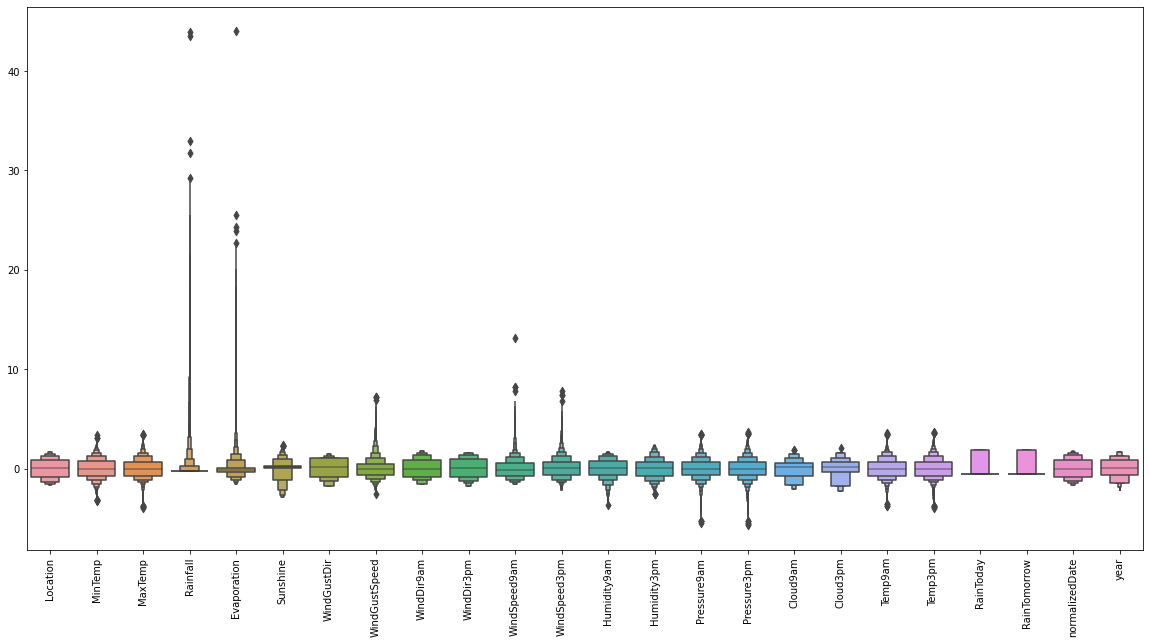

In [106]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
plt.xticks(rotation=90)
plt.show()

# Model

In [146]:
X = features.drop(["RainTomorrow"], axis=1)
y = target

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [153]:
model = None

In [181]:
#Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising

model = keras.Sequential()

# layers

model.add(layers.Dense(units = 32, kernel_initializer = 'uniform', activation = 'elu', input_dim = 23))
model.add(layers.Dense(units = 32, kernel_initializer = 'uniform', activation = 'elu'))
model.add(layers.Dense(units = 16, kernel_initializer = 'uniform', activation = 'elu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(units = 8, kernel_initializer = 'uniform', activation = 'elu'))
model.add(layers.Dense(units = 4 , kernel_initializer = 'uniform', activation = 'elu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling
opt =  keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train
history = model.fit(X_train, y_train, batch_size = 64, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
1455/1455 [==============================] - 4s 3ms/step - loss: 0.4085 - accuracy: 0.8253 - val_loss: 0.3713 - val_accuracy: 0.8427
Epoch 2/150
1455/1455 [==============================] - 3s 2ms/step - loss: 0.3890 - accuracy: 0.8322 - val_loss: 0.3699 - val_accuracy: 0.8387
Epoch 3/150
1455/1455 [==============================] - 3s 2ms/step - loss: 0.3841 - accuracy: 0.8330 - val_loss: 0.3608 - val_accuracy: 0.8461
Epoch 4/150
1455/1455 [==============================] - 3s 2ms/step - loss: 0.3826 - accuracy: 0.8331 - val_loss: 0.3586 - val_accuracy: 0.8448
Epoch 5/150
1455/1455 [==============================] - 3s 2ms/step - loss: 0.3809 - accuracy: 0.8343 - val_loss: 0.3580 - val_accuracy: 0.8467
Epoch 6/150
1455/1455 [==============================] - 3s 2ms/step - loss: 0.3781 - accuracy: 0.8363 - val_loss: 0.3572 - val_accuracy: 0.8499
Epoch 7/150
1455/1455 [==============================] - 3s 2ms/step - loss: 0.3760 - accuracy: 0.8392 - val_loss: 0.3629 - val_ac

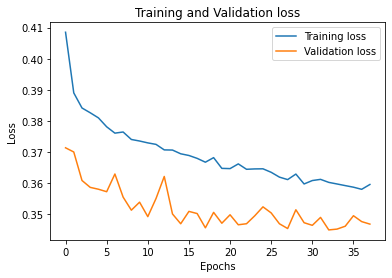

In [182]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

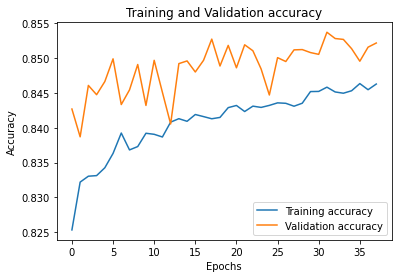

In [183]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']],  label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']],  label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [184]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

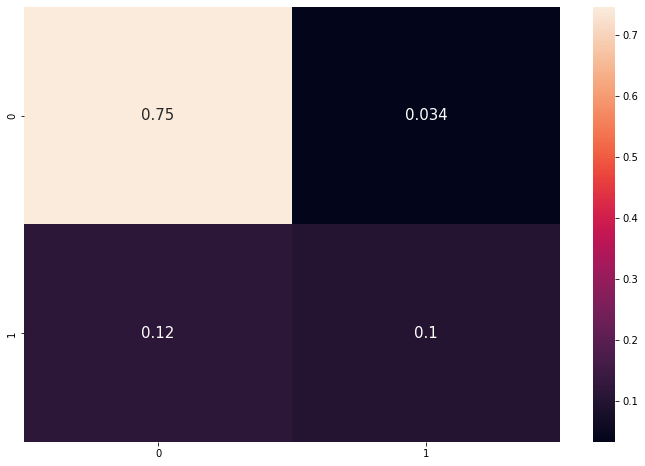

In [185]:
# confusion matrix
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix),annot = True, annot_kws = {'size':15})

In [186]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     22672
           1       0.75      0.47      0.58      6420

    accuracy                           0.85     29092
   macro avg       0.81      0.71      0.74     29092
weighted avg       0.84      0.85      0.83     29092

